# Interpreting Taste in Movies

Today, we will be testing Bourdieu’s theory of taste in contemporary movies. Specifically, in the past ten years, is good taste in movies still something that is learned and replicated in elite codes, through the institution of the movie critic? To empirically answer this question, we will address the following:

1. In the past ten years, how influential are movie critic reviews in which movies are nominated for/win awards?
    * Theoretically: Critical approval (good taste, SV), conventionally indexes prestige and distinction (O), which then is associated with the act of appreciating a film (I)
    * Empirically: Does the probability of being nominated for an award go up with critical approval (i.e. critic scores for a movie) and down for mass approval (user scores for a movie). Historically the stamp of approval/distinction in the movie industry has been awards like the Oscars. Therefore, we will use the receipt of these awards as our outcome variable, assuming that good taste in movies can be intepreted thorugh the movies that win awards.

2. Do critics still stand in opposition to movies that the masses enjoy? I.e. are critics still the gateways for elite codes?
    * As above, critical approval indexes elite distinction from the masses
    * Empirically: critical reviews should be either negatively or non-correlated with box-office numbers (reflecting mass enjoyment) if this theory holds

3. Are “difficult” genres and words used to describe films that are nominated for awards?
    * Theoretically: The incorporation of difficult themes and language in a movie (SV) indexes a certain ideal of high culture and sophistication (O), which is then associated with the act of appreciating a film and being sophisticated enough to understand it (I) in contrast to the "masses" who only enjoy “low brow” films
    * Empirically: does the probability of being nominated for an award go up for "serious" genres such as drama (in comparison to comedy, for example)? How about for longer movie runtimes? For "PG-13" and "R" rated movies? For plot descriptions that closely mimic a movie critic's writing style?
    
To address these questions, we will rely on large text datasets from [IMDb](https://www.imdb.com/interfaces/) to identify all of the listed movies from the past 10 years, along with basic metadata about them (such as user reviews on IMDb). IMDb, however, does not give us access to awards information, critical review data, or plot description information in their available text files. For this, we will turn to the [OMDb API](http://www.omdbapi.com/) (Open Movie Database), which allows us to download all of this information, using the IMDb IDs for each movie to link movie information.

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import re
import omdb
import requests
import json
import nltk
import string
from gensim import corpora, models

def logit_and_plot(formula, data, plot_title):
    # Fit Logistic Regression Model and print summary:
    logitfit = smf.logit(formula = formula, data = data).fit()
    print(logitfit.summary())
    
    # Plot only if I'm plotting for a single variable logistic regression
    
    # Make Logistic Regression Predictions for each set of ratings:
    probabilities = pd.DataFrame(logitfit.predict(), index=data.index)
    df = pd.DataFrame()
    if len(formula.split(" ")) > 3:
        return logitfit
    elif 'averageRating' in formula.split(" "):
        df = pd.DataFrame({
            'Rating':data['averageRating'],
            'P(Award)':probabilities[0]
            })
    elif 'polarization' in formula.split(" "):
        df = pd.DataFrame({
            'Rating':data['polarization'],
            'P(Award)':probabilities[0]
            })
    else:
        df = pd.DataFrame({
            'Rating':data['metascore'],
            'P(Award)':probabilities[0]
            })
    
    # Plot mean predictions for each value if only plotting for a single variable
    df.groupby(df.Rating).agg({'P(Award)':np.mean}).plot()
    plt.title(plot_title)
    plt.xlabel('Rating')
    plt.ylabel('Probability')
    plt.show();
    
    # Return the logistic regression model itself
    return logitfit

def get_movie_data(imdb_id):
    # Get Movie Dictionary via OMDb API, using IMDb ID #, note omdb api key needs to be filled in:
    movie = requests.get('http://www.omdbapi.com/?i=' + imdb_id + '&plot=full&apikey=########', timeout=None)
    movie = json.loads(movie.text, strict=False)

    # Get Desired Data entries from OMDb dictionary:
    rated = movie.get('Rated')
    plot = movie.get('Plot')
    metascore = movie.get('Metascore')
    box_office = movie.get('BoxOffice')
    awards = movie.get('Awards')
    
    # Return Entries as a Series to be added as new DataFrame rows
    return pd.Series([rated, plot, metascore, box_office, awards])

def get_wordnet_pos(word):

    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": nltk.corpus.wordnet.ADJ,
                "N": nltk.corpus.wordnet.NOUN,
                "V": nltk.corpus.wordnet.VERB,
                "R": nltk.corpus.wordnet.ADV}

    return tag_dict.get(tag, nltk.corpus.wordnet.NOUN)

def get_lemmas(text):

    stop = nltk.corpus.stopwords.words('english') + list(string.punctuation)
    tokens = [i for i in nltk.word_tokenize(text.lower()) if i not in stop]
    lemmas = [nltk.stem.WordNetLemmatizer().lemmatize(t, get_wordnet_pos(t)) for t in tokens]
    return lemmas

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

C:\Users\Jon Clindaniel\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


To start, let's load all of the IMDb text files that are available to directly download from IMDb's website. These each contain different types of information about all of the movies that are listed on IMDb. We will want to filter this down to entries that are specifically "movies" and came out after 2009, so that we don't have to keep operating on such a big dataset in memory.

In [268]:
imdb_list = pd.read_csv('imdb_list.tsv', sep='\t')
imdb_info = pd.read_csv('imdb_info.tsv', sep='\t')
imdb_user_ratings = pd.read_csv('imdb_ratings.tsv', sep='\t')

------------------

First of all, let's filter out any items that are not movies, or that occured in 2009 or before, or that are listed as "Adult" content:

In [16]:
# Any terms that can't be turned into numerical values return NA, take movies from the past ten years that are not Adult

imdb_movies = imdb_list[(imdb_list['titleType'] == 'movie') &
                        (pd.to_numeric(imdb_list['startYear'], errors='coerce') > 2009) &
                        (imdb_list['isAdult'] == 0)
                       ]
imdb_movies.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
67693,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018,\N,122,Drama
67839,tt0069204,movie,Sabse Bada Sukh,Sabse Bada Sukh,0,2018,\N,\N,"Comedy,Drama"
84110,tt0085953,movie,Devil Fetus,Mo tai,0,2019,\N,84,Horror
98090,tt0100275,movie,The Wandering Soap Opera,La Telenovela Errante,0,2017,\N,80,"Comedy,Drama,Fantasy"
109014,tt0111414,movie,A Thin Life,A Thin Life,0,2018,\N,75,Comedy


Next, let's merge these films together with films that have information on regional distributions. Right now, we are including all films, whether they had US regional distributions or not. For the purposes of our questions, we will just be focusing on films that had US regional distributions, so we will need to filter out any entries that were not distributed here.

In [17]:
# Only look at films that had a USA distribution and drop any duplicate entries; returns >50k movies
imdb_movie_info = pd.merge(imdb_movies, imdb_info, how='inner', left_on='tconst', right_on='titleId')
imdb_movies_usa = imdb_movie_info[imdb_movie_info['region'] == 'US'].drop_duplicates('tconst')
imdb_movies_usa.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
6,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018,\N,122,Drama,tt0069049,2,The Other Side of the Wind,US,\N,imdbDisplay,\N,0
23,tt0112502,movie,Bigfoot,Bigfoot,0,2017,\N,\N,"Horror,Thriller",tt0112502,1,Bigfoot,US,\N,\N,\N,0
44,tt0159369,movie,Cooper and Hemingway: The True Gen,Cooper and Hemingway: The True Gen,0,2013,\N,180,Documentary,tt0159369,3,Cooper and Hemingway: The True Gen,US,\N,\N,\N,0
54,tt0192528,movie,Heaven & Hell,Reverse Heaven,0,2018,\N,104,Drama,tt0192528,1,Heaven & Hell,US,\N,imdbDisplay,\N,0
56,tt0230212,movie,The Final Journey,The Final Journey,0,2010,\N,120,Drama,tt0230212,1,The Final Journey,US,\N,\N,\N,0


One of our main concerns is how user ratings of films compare to critic ratings of films. IMDb gives us the average user rating for each film in their available text files, so let's merge that file with the filtered dataframe we created above to get the average user rating for each film that was distributed in the US from 2010 to today. We will also drop any film that has less 10 user reviews, so that these averages are not too biased by any single review.

In [18]:
# Only keep films that have 10 user ratings (i.e. are likely to have been seen by more than a couple of people):
imdb_movies_usa_w_ratings = pd.merge(imdb_movies_usa, imdb_user_ratings, how='inner', on='tconst')
imdb_movies_final = imdb_movies_usa_w_ratings[imdb_movies_usa_w_ratings['numVotes'] >= 10]
imdb_movies_final.head() #leaves us with 23,608 movies

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,titleId,ordering,title,region,language,types,attributes,isOriginalTitle,averageRating,numVotes
0,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018,\N,122,Drama,tt0069049,2,The Other Side of the Wind,US,\N,imdbDisplay,\N,0,6.9,4981
1,tt0112502,movie,Bigfoot,Bigfoot,0,2017,\N,\N,"Horror,Thriller",tt0112502,1,Bigfoot,US,\N,\N,\N,0,4.1,32
2,tt0159369,movie,Cooper and Hemingway: The True Gen,Cooper and Hemingway: The True Gen,0,2013,\N,180,Documentary,tt0159369,3,Cooper and Hemingway: The True Gen,US,\N,\N,\N,0,7.6,53
3,tt0192528,movie,Heaven & Hell,Reverse Heaven,0,2018,\N,104,Drama,tt0192528,1,Heaven & Hell,US,\N,imdbDisplay,\N,0,3.9,74
5,tt0249516,movie,Foodfight!,Foodfight!,0,2012,\N,91,"Action,Animation,Comedy",tt0249516,2,Foodfight!,US,\N,\N,\N,0,1.6,8789


We still don't have critic reviews, though. IMDb would require us to pay for their IMDb Pro service in order to access this information, along with box office information, plot descriptions, and award information. We can, however, use the user-contributed OMDb API to access this information freely. OMDb takes IMDb ID numbers (column `tconst` in `imdb_movies_final`) as a parameter, so we simply need to feed in these ID numbers in order to return this additional information about each movie. We'll then write this information directly to DataFrame columns in our `imdb_movies_final` DataFrame.

Note that it takes a long time to access the API ~25k times (and you need to obtain an OMDb API Key--see the function `get_movie_data` at the beginning of this notebook for more information on where you should provide the key), so this code is commented out. The files `imdb_omdb_movies_final.pkl` and `imdb_omdb_movies_final.csv` both contain the end result of these operations and you can load either one of those to proceed with the notebook

In [2]:
#imdb_movies_final[['rated','plot','metascore','box_office','awards']] = imdb_movies_final['tconst'].apply(get_movie_data)
#imdb_movies_final.to_csv('imdb_omdb_movies_final.csv')
#imdb_movies_final.to_pickle('imdb_omdb_movies_final.pkl') # also pickled, just in case there are any errors in csv

# Read data from either Pickle or CSV
# imdb_movies_final = pd.read_csv('imdb_omdb_movies_final.csv')
imdb_movies_final = pd.read_pickle('imdb_omdb_movies_final.pkl')
imdb_movies_final.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,titleId,...,types,attributes,isOriginalTitle,averageRating,numVotes,rated,plot,metascore,box_office,awards
0,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018,\N,122,Drama,tt0069049,...,imdbDisplay,\N,0,6.9,4981,R,A Hollywood director emerges from semi-exile w...,78.0,NaN,NaN
1,tt0112502,movie,Bigfoot,Bigfoot,0,2017,\N,\N,"Horror,Thriller",tt0112502,...,\N,\N,0,4.1,32,NaN,NaN,NaN,NaN,NaN
2,tt0159369,movie,Cooper and Hemingway: The True Gen,Cooper and Hemingway: The True Gen,0,2013,\N,180,Documentary,tt0159369,...,\N,\N,0,7.6,53,NaN,Cooper and Hemingway: The True Gen is an unpre...,54.0,NaN,NaN
3,tt0192528,movie,Heaven & Hell,Reverse Heaven,0,2018,\N,104,Drama,tt0192528,...,imdbDisplay,\N,0,3.9,74,NaN,"In 1990s Los Angeles, danger lurks around the ...",NaN,NaN,NaN
4,tt0249516,movie,Foodfight!,Foodfight!,0,2012,\N,91,"Action,Animation,Comedy",tt0249516,...,\N,\N,0,1.6,8789,PG,"When the supermarket closes at night, the cont...",NaN,NaN,NaN


Now that we have our data, let's take a look at our questions.

## 1. In the past ten years, how influential are movie critic reviews in which movies are nominated for/win awards?
    * Theoretically: Critical approval (good taste, SV), conventionally indexes prestige and distinction (O), which then is associated with the act of appreciating a film (I)
    * Empirically: Does the probability of being nominated for an award go up with critical approval (i.e. critic scores for a movie) and down for mass approval (user scores for a movie). Historically the stamp of approval/distinction in the movie industry has been awards like the Oscars. Therefore, we will use the receipt of these awards as our outcome variable, assuming that good taste in movies can be intepreted through the movies that win awards.
    * Empirically, in the case in which there is high polarization between critics and the masses, we should also see that high polarization that favors critics predicts award nominations, whereas high polarization that favors the masses should not be predictive of award nominations
    
To begin to address this question. let's first bracket off the data we are going to use to address the question in a new dataframe, specifically filtering out any movies that do not have a critic "metascore."

In [24]:
movie_ratings = imdb_movies_final[['tconst', 'averageRating', 'metascore', 'awards']][~imdb_movies_final['metascore'].isnull()]
movie_ratings.head(15)

,tconst,averageRating,metascore,awards
0,tt0069049,6.9,78.0,NaN
2,tt0159369,7.6,54.0,NaN
13,tt0326965,5.5,33.0,6 wins.
20,tt0359950,7.3,54.0,5 wins & 18 nominations.
22,tt0365545,6.4,63.0,NaN
23,tt0365907,6.5,57.0,1 nomination.
24,tt0369610,7.0,59.0,14 wins & 57 nominations.
26,tt0376136,6.2,56.0,2 wins & 4 nominations.
27,tt0377981,5.9,53.0,Nominated for 1 Golden Globe. Another 1 win & ...
28,tt0383010,5.0,56.0,4 nominations.


Our award information is unfortunately in the form of text strings. In order to identify whether a film won an Oscar, or any award at all, we will need to write functions that designate whether these specific entries are included in the awards column. Let's look to see if there is any award associated with a movie (i.e. the awards row value is not NaN) and then if any of the awards are listed as being Oscars.

In [29]:
def any_award(awards):
    # If any award, return 1, else 0
    if pd.isnull(awards):
        return 0
    else:
        return 1
def oscar(awards):
    # If any Oscar, return 1, else 0
    if 'oscar' in re.sub(r'[^\w\s]','', str(awards)).lower().split():
        return 1
    else:
        return 0   

# Make column that is '1' if the movie won any award, '0' if no award
movie_ratings['Any_Award'] = movie_ratings['awards'].apply(any_award)

# Make additional column that is '1' if the movie won an Oscar, '0' if no Oscar
movie_ratings['Oscar'] = movie_ratings['awards'].apply(oscar)

In [30]:
movie_ratings.head(15)

,tconst,averageRating,metascore,awards,polarization,Any_Award,Oscar
0,tt0069049,690.0,78.0,NaN,-612.0,0,0
2,tt0159369,760.0,54.0,NaN,-706.0,0,0
13,tt0326965,550.0,33.0,6 wins.,-517.0,1,0
20,tt0359950,730.0,54.0,5 wins & 18 nominations.,-676.0,1,0
22,tt0365545,640.0,63.0,NaN,-577.0,0,0
23,tt0365907,650.0,57.0,1 nomination.,-593.0,1,0
24,tt0369610,700.0,59.0,14 wins & 57 nominations.,-641.0,1,0
26,tt0376136,620.0,56.0,2 wins & 4 nominations.,-564.0,1,0
27,tt0377981,590.0,53.0,Nominated for 1 Golden Globe. Another 1 win & ...,-537.0,1,0
28,tt0383010,500.0,56.0,4 nominations.,-444.0,1,0


Let's make sure that average user rating and metascore are on the same scale and that they're both numbers. We'll also add in a column called "polarization", where big negative numbers indicate the masses loved a movie but critics hated it and big positive numbers indicate that the critics loved a movie but the masses hated it (zero indicates mass and critical agreement).

In [31]:
# Scale average Rating to the same 100-pt scale as metascore
movie_ratings['averageRating'] = movie_ratings['averageRating']*10

# Convert Metascores to numeric values (not automatically identified as such upon upload):
movie_ratings['metascore'] = pd.to_numeric(movie_ratings['metascore'])

# Add a column for measuring Critic-Mass polarization: (Metascore - averageRating)
movie_ratings['polarization'] = movie_ratings['metascore'].subtract(movie_ratings['averageRating'])

In [32]:
movie_ratings.head()

,tconst,averageRating,metascore,awards,polarization,Any_Award,Oscar
0,tt0069049,6900.0,78.0,NaN,-6822.0,0,0
2,tt0159369,7600.0,54.0,NaN,-7546.0,0,0
13,tt0326965,5500.0,33.0,6 wins.,-5467.0,1,0
20,tt0359950,7300.0,54.0,5 wins & 18 nominations.,-7246.0,1,0
22,tt0365545,6400.0,63.0,NaN,-6337.0,0,0


Now that we have our data, let's plot a quick series of scatter plots of the data to see if we can identify any obvious relationships between variables. Things to note:
1. Average User Ratings and Critic metascores are visibly higher than average for Oscar Nominated/winning movies.
2. Average User Ratings/Critic metascores are correlated and we'll have to control for this when we're trying to disentangle their respective effects on Award nominations/wins.
3. Polarization also is visibly higher than average for Oscar Nominated/winning movies and is correlated with Metascore (more polarization where the masses don't like a critic-approved movie is strongly associated with higher critic ratings, but negative polarization where the masses like a critic-disapproved movie is strongly associated with lower critic ratings), but not average user rating. We'll also need to disentangle this as we continue our analysis to interpret why this relationship might be the case

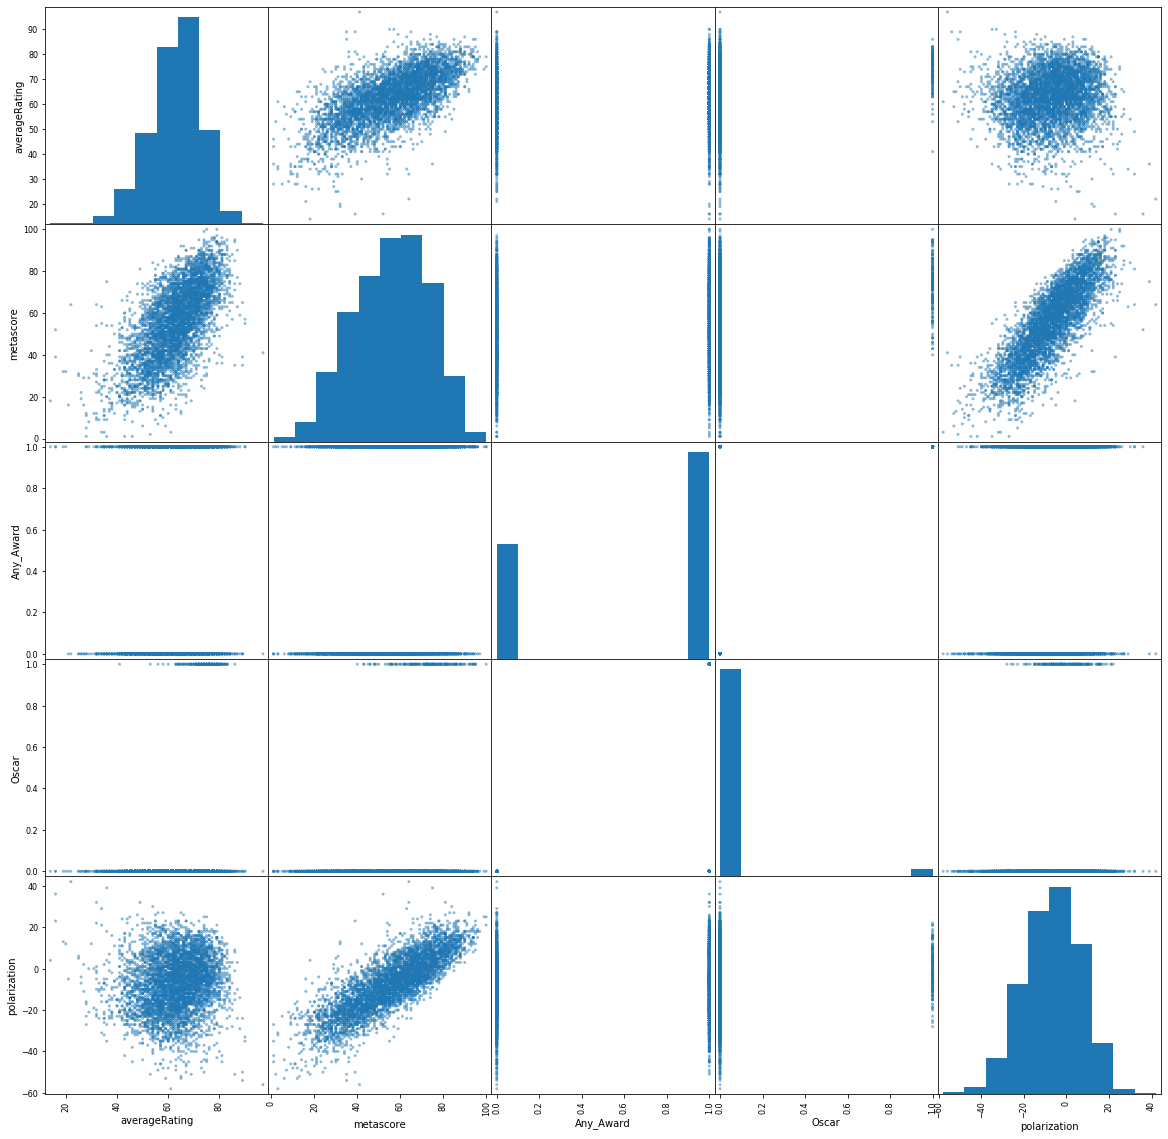

In [8]:
pd.plotting.scatter_matrix(movie_ratings, figsize=(20,20));

To model these relationships more formally and identify which variables are the most predictive of winning an award, we will use an approach called logistic regression. In [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression), we model the log odds (as the name suggests, the log form of the odds--a transformation done to make the math slightly easier in the regression) of a particular binary outcome, in the case, the odds that a movie receives an award or not. The coefficients in front of each predictor variable in logistic regression correspond to increases (positive coefficent) and decreases (negative coefficient) in the probability of an Award over the probability of no Award.

If we model the odds of a movie getting an award as a function of average user rating and critical metascore, we can identify the unique contribution that users and critics make in predicting an award for a movie (if there is a statistically significant one). Because we know from the scatter plot above that user and critic reviews are correlated, though, we'll need to add another variable for the interaction that the two scores seem to have with one another to account for this potential "interaction effect." We can do this like so, through a series of logistic regression equations that model different levels of variable contributions.

From the results below, we can see that the interaction term is not statistically significant, but average user ratings and average critic ratings seem to have a nearly identical (statistically significant) effect in increasing the probability of a movie getting an award. If only critics had a role in defining the "taste" required for a movie to be distinguished with an award, we would expect the metascore to be the only variable that plays a difference in this equation. It seems average users have more influence than predicted.

Optimization terminated successfully.
         Current function value: 0.634984
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              Any_Award   No. Observations:                 4977
Model:                          Logit   Df Residuals:                     4975
Method:                           MLE   Df Model:                            1
Date:                Thu, 14 Nov 2019   Pseudo R-squ.:                 0.02635
Time:                        09:20:09   Log-Likelihood:                -3160.3
converged:                       True   LL-Null:                       -3245.8
Covariance Type:            nonrobust   LLR p-value:                 4.347e-39
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -1.8420      0.191     -9.649      0.000      -2.216      -1.468
averageRating     0.

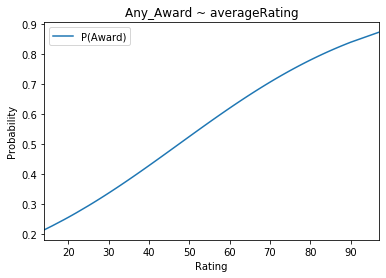

Optimization terminated successfully.
         Current function value: 0.630757
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              Any_Award   No. Observations:                 4977
Model:                          Logit   Df Residuals:                     4975
Method:                           MLE   Df Model:                            1
Date:                Thu, 14 Nov 2019   Pseudo R-squ.:                 0.03283
Time:                        09:20:09   Log-Likelihood:                -3139.3
converged:                       True   LL-Null:                       -3245.8
Covariance Type:            nonrobust   LLR p-value:                 2.840e-48
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.7732      0.098     -7.862      0.000      -0.966      -0.580
metascore      0.0248      0.

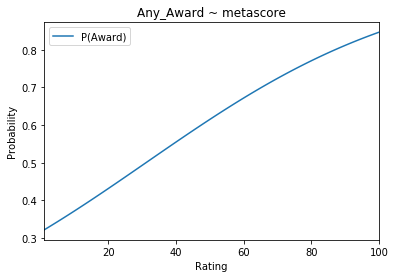

Optimization terminated successfully.
         Current function value: 0.628545
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              Any_Award   No. Observations:                 4977
Model:                          Logit   Df Residuals:                     4974
Method:                           MLE   Df Model:                            2
Date:                Thu, 14 Nov 2019   Pseudo R-squ.:                 0.03622
Time:                        09:20:09   Log-Likelihood:                -3128.3
converged:                       True   LL-Null:                       -3245.8
Covariance Type:            nonrobust   LLR p-value:                 8.654e-52
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -1.5519      0.194     -7.997      0.000      -1.932      -1.172
averageRating     0.

In [6]:
f_any_user = 'Any_Award ~ averageRating'
f_any_critic = 'Any_Award ~ metascore'
f_any_simp = 'Any_Award ~ averageRating + metascore'
f_any_interaction = 'Any_Award ~ averageRating + metascore + averageRating*metascore'
    
logit_and_plot(formula = f_any_user, data = movie_ratings, plot_title = f_any_user)

logit_and_plot(formula = f_any_critic, data = movie_ratings, plot_title = f_any_critic)

logit_and_plot(formula = f_any_simp, data = movie_ratings, plot_title = f_any_simp)

logit_and_plot(formula = f_any_interaction, data = movie_ratings, plot_title = f_any_interaction)

Interestingly, though, if we perform the same routine for the odds of winning or being nominated for an Oscar, the premier movie award, we can see that the only variable within the realm of statistical significance (at p=.067, but still quite low) in increasing the probability of winning/being nominated for an Oscar is average user rating. This is not expected under the theory that expert critics are the taste-makers in deciding what makes a movie good or not. Perhaps average users are taking on more of a role in taste-making than was possible in other media regimes.

Optimization terminated successfully.
         Current function value: 0.127102
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                  Oscar   No. Observations:                 4977
Model:                          Logit   Df Residuals:                     4975
Method:                           MLE   Df Model:                            1
Date:                Wed, 13 Nov 2019   Pseudo R-squ.:                  0.1795
Time:                        14:48:40   Log-Likelihood:                -632.59
converged:                       True   LL-Null:                       -770.95
Covariance Type:            nonrobust   LLR p-value:                 3.874e-62
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -14.3470      0.830    -17.288      0.000     -15.974     -12.720
averageRating     0.

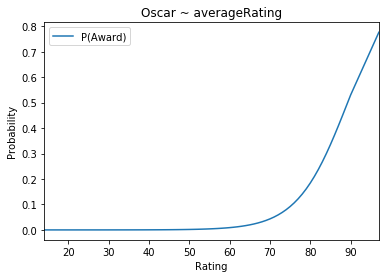

Optimization terminated successfully.
         Current function value: 0.133657
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                  Oscar   No. Observations:                 4977
Model:                          Logit   Df Residuals:                     4975
Method:                           MLE   Df Model:                            1
Date:                Wed, 13 Nov 2019   Pseudo R-squ.:                  0.1372
Time:                        14:48:40   Log-Likelihood:                -665.21
converged:                       True   LL-Null:                       -770.95
Covariance Type:            nonrobust   LLR p-value:                 6.528e-48
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -8.2533      0.446    -18.524      0.000      -9.127      -7.380
metascore      0.0763      0.

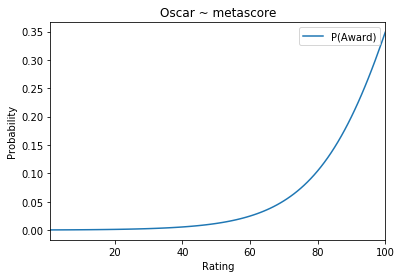

Optimization terminated successfully.
         Current function value: 0.123588
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                  Oscar   No. Observations:                 4977
Model:                          Logit   Df Residuals:                     4974
Method:                           MLE   Df Model:                            2
Date:                Wed, 13 Nov 2019   Pseudo R-squ.:                  0.2022
Time:                        14:48:40   Log-Likelihood:                -615.10
converged:                       True   LL-Null:                       -770.95
Covariance Type:            nonrobust   LLR p-value:                 2.059e-68
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -14.5403      0.874    -16.642      0.000     -16.253     -12.828
averageRating     0.

In [12]:
f_oscar_user = 'Oscar ~ averageRating'
f_oscar_critic = 'Oscar ~ metascore'
f_oscar_simp = 'Oscar ~ averageRating + metascore'
f_oscar_interaction = 'Oscar ~ averageRating + metascore + averageRating*metascore'
    
logit_and_plot(formula = f_oscar_user, data = movie_ratings, plot_title = f_oscar_user)

logit_and_plot(formula = f_oscar_critic, data = movie_ratings, plot_title = f_oscar_critic)

logit_and_plot(formula = f_oscar_simp, data = movie_ratings, plot_title = f_oscar_simp)

logit_and_plot(formula = f_oscar_interaction, data = movie_ratings, plot_title = f_oscar_interaction)

Alternatively, we can frame this in terms of polarization. We saw for instance a correlation between polarization and metascore, but not between average user rating and polarization. Theoretically, highly polarized movies should favor the critics' interpretation.

However, we can see below that adding in polarization as a interaction effect actually works in favor of the average user scores. We still see strong boost in probability via average user rating and only negative or non-existent boosts on behalf of critics. Also, interaction effects are relatively small in comparison to the average user score effect, so polarization seems to have limited effect on this relationship.

In [34]:
f_any = 'Any_Award ~ metascore + averageRating + metascore:averageRating + metascore:polarization + averageRating:polarization'
f_oscar = 'Oscar ~ metascore + averageRating + metascore:averageRating + metascore:polarization + averageRating:polarization'

logit_and_plot(formula = f_any, data = movie_ratings, plot_title = f_any)
logit_and_plot(formula = f_oscar, data = movie_ratings, plot_title = f_oscar)

Optimization terminated successfully.
         Current function value: 0.626666
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              Any_Award   No. Observations:                 4977
Model:                          Logit   Df Residuals:                     4971
Method:                           MLE   Df Model:                            5
Date:                Thu, 14 Nov 2019   Pseudo R-squ.:                 0.03910
Time:                        13:26:05   Log-Likelihood:                -3118.9
converged:                       True   LL-Null:                       -3245.8
Covariance Type:            nonrobust   LLR p-value:                 8.190e-53
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -3.7743      0.779     -4.845      0.000      

Moving on to our second question:

## 2. Do critics still stand in opposition to movies that the masses enjoy? I.e. are critics still the gateways for elite codes?
    * As above, critical approval indexes elite distinction from the masses
    * Empirically: critical reviews should be either negatively or non-correlated with box-office numbers (reflecting mass enjoyment) if this theory holds
    
First, let's define a function that cleans up the box numbers, so that they don't have commas and dollar signs in them. After this looks good, let's take the log of our dollar amounts, since some are orders of magnitude large than others and it will be challenging to model and interpret them without this transformation.

In [35]:
def box_office_usd(box_office):
    # return box office values without $ signs or commas:
    box_office_val = float(re.sub('[^.0-9]', '', box_office))
    return box_office_val

# Drop anything where box office is null, or metascore is null (this is what we'll be comparing box office numbers against)
box_office = imdb_movies_final[['tconst', 'box_office']][(~imdb_movies_final['box_office'].isnull()) & 
                                                         (~imdb_movies_final['metascore'].isnull())]

# Clean Box Office Data:
box_office['box_office'] = box_office['box_office'].apply(box_office_usd)

box_office.head(10)

,tconst,box_office
20,tt0359950,33223430.0
24,tt0369610,528757749.0
26,tt0376136,13000000.0
27,tt0377981,99808609.0
28,tt0383010,41800000.0
31,tt0398286,200803309.0
33,tt0401729,73058679.0
36,tt0409379,308227.0
37,tt0409847,100215116.0
44,tt0427152,72980108.0


In [36]:
ratings_box_office = pd.merge(box_office, movie_ratings, on='tconst')
ratings_box_office['box_office'] = np.log10(ratings_box_office['box_office'])
ratings_box_office.replace([np.inf, -np.inf], np.nan, inplace=True)

ratings_box_office.head()

,tconst,box_office,averageRating,metascore,awards,polarization,Any_Award,Oscar
0,tt0359950,7.521444,7300.0,54.0,5 wins & 18 nominations.,-7246.0,1,0
1,tt0369610,8.723257,7000.0,59.0,14 wins & 57 nominations.,-6941.0,1,0
2,tt0376136,7.113943,6200.0,56.0,2 wins & 4 nominations.,-6144.0,1,0
3,tt0377981,7.999168,5900.0,53.0,Nominated for 1 Golden Globe. Another 1 win & ...,-5847.0,1,0
4,tt0383010,7.621176,5000.0,56.0,4 nominations.,-4944.0,1,0


Taking a look at the relationships between the variables in this new dataframe, I see limited relationship between box office numbers and ratings in general, although box office numbers for average users seem to be slightly more concentrated.

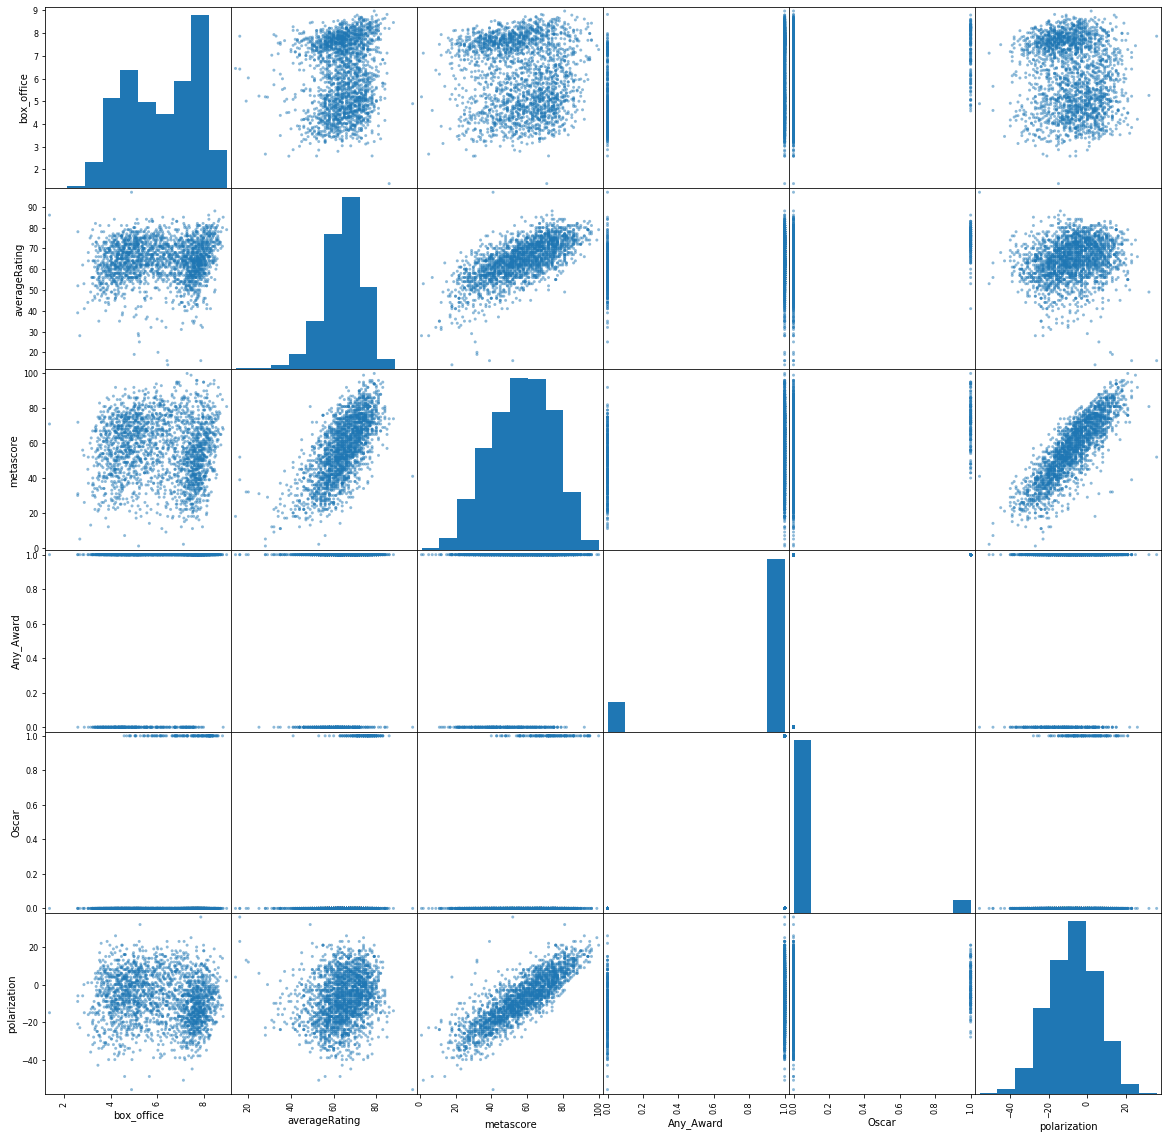

In [25]:
pd.plotting.scatter_matrix(ratings_box_office, figsize=(20,20));

Let's model this relationship between critical reception and box office numbers more formally using linear regression.

From the model below, we can see that there is a weak, slightly negative relationship between critical reception and box office numbers. This is consistent with the theory that critics tend to position themselves against the commercially successful films. On the other hand, the average rating for users seems to very slightly predict box office ratings. This is a near-zero effect, though.

In [38]:
mod = smf.ols(formula='box_office ~ metascore', data=ratings_box_office)
res = mod.fit()
print(res.summary())

mod = smf.ols(formula='box_office ~ averageRating', data=ratings_box_office)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             box_office   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     5.193
Date:                Thu, 14 Nov 2019   Prob (F-statistic):             0.0228
Time:                        13:36:59   Log-Likelihood:                -4008.6
No. Observations:                2178   AIC:                             8021.
Df Residuals:                    2176   BIC:                             8033.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.3964      0.112     57.300      0.0

Moving on to our final question:
## 3. Are “difficult” genres and words used to describe films that are nominated for awards?
    * Theoretically: The incorporation of difficult themes and language in a movie (SV) indexes a certain ideal of high culture and sophistication (O), which is then associated with the act of appreciating a film and being sophisticated enough to understand it (I) in contrast to the "masses" who only enjoy “low brow” films
    * Empirically: does the probability of being nominated for an award go up for "serious" genres such as drama (in comparison to comedy, for example)? How about for longer movie runtimes? For "PG-13" and "R" rated movies? For plot descriptions that closely mimic a movie critic's writing style?
    
Let's get the variables we'll be working with to answer the question:

In [9]:
movie_difficulty = imdb_movies_final[['tconst', 'runtimeMinutes', 'genres','rated','plot']][
                                                                                (~imdb_movies_final['rated'].isnull()) & 
                                                                                (~imdb_movies_final['plot'].isnull())]
movie_difficulty.head()

,tconst,runtimeMinutes,genres,rated,plot
0,tt0069049,122,Drama,R,A Hollywood director emerges from semi-exile w...
4,tt0249516,91,"Action,Animation,Comedy",PG,"When the supermarket closes at night, the cont..."
6,tt0285252,100,Comedy,R,Darren gets stood up on the day of his wedding...
13,tt0326965,104,"Drama,Mystery,Thriller",PG-13,Marcus is a popular massage therapist who stru...
16,tt0331314,84,"Adventure,Animation,Comedy",PG,12 year old Travis Barclay and his little sist...


In [10]:
# Merge movie_difficulty with ratings dataframe so that we can access user/critic ratings and awards information
ratings_difficulty = pd.merge(movie_difficulty, movie_ratings, on='tconst')
ratings_difficulty['runtimeMinutes'] = pd.to_numeric(ratings_difficulty['runtimeMinutes'])
ratings_difficulty.head()

,tconst,runtimeMinutes,genres,rated,plot,averageRating,metascore,awards,Any_Award,Oscar,polarization
0,tt0069049,122,Drama,R,A Hollywood director emerges from semi-exile w...,69.0,78.0,NaN,0,0,9.0
1,tt0326965,104,"Drama,Mystery,Thriller",PG-13,Marcus is a popular massage therapist who stru...,55.0,33.0,6 wins.,1,0,-22.0
2,tt0359950,114,"Comedy,Drama,Fantasy",PG,The manager of the negative assets sector of L...,73.0,54.0,5 wins & 18 nominations.,1,0,-19.0
3,tt0365545,98,"Comedy,Drama,Romance",TV-MA,Violet Jones tired of waiting for her longtime...,64.0,63.0,NaN,0,0,-1.0
4,tt0365907,114,"Action,Crime,Drama",R,Matt Scudder is a former cop now a private eye...,65.0,57.0,1 nomination.,1,0,-8.0


We can see that there might be a slight association between runtime and the odds of getting an award, as well as the average rating for critics and users. We'll need to check to see if this is a statistically significant relationship

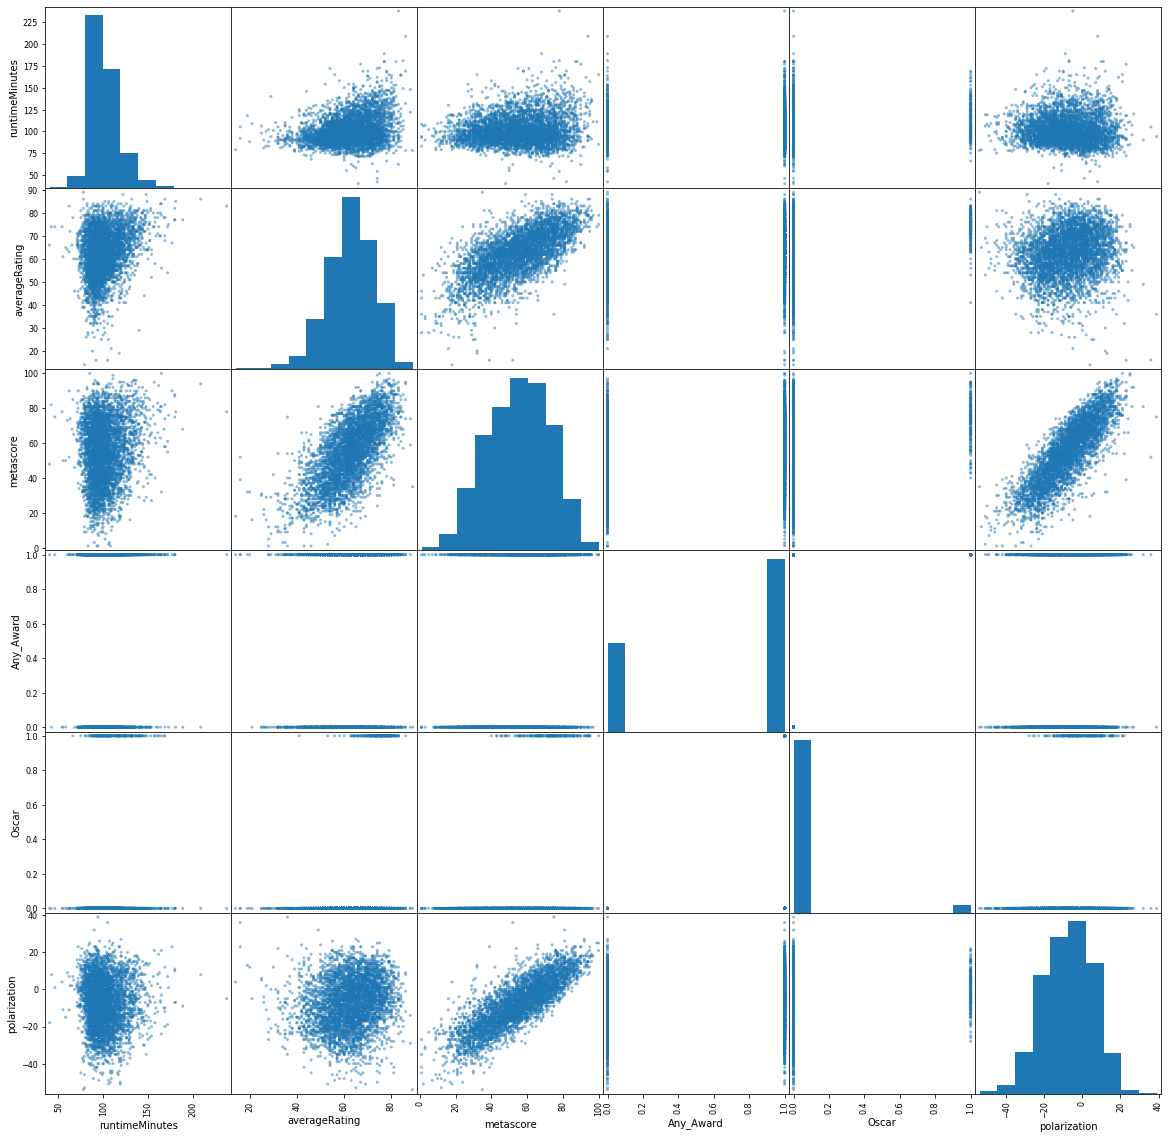

In [36]:
pd.plotting.scatter_matrix(ratings_difficulty, figsize=(20,20));

Checking to see if there is a statistically significant relationship between the probability of being nominated for an Oscar and the content rating of a movie, we can see there are slight advantages to your movie being rated above the rating "G", but "R" is not the most predictive category (i.e there are still a lot of bad "R" movies and that is not the only indicator)

In [239]:
mod = smf.logit(formula='Oscar ~ C(rated)', data=ratings_difficulty[(ratings_difficulty['rated'] == 'R') |
                                                               (ratings_difficulty['rated'] == 'PG-13') |
                                                               (ratings_difficulty['rated'] == 'PG') |
                                                               (ratings_difficulty['rated'] ==  'G')
                                                              ])
res = mod.fit()
print(res.summary())

mod = smf.logit(formula='Oscar ~ runtimeMinutes', data=ratings_difficulty)

res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.202837
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  Oscar   No. Observations:                 3013
Model:                          Logit   Df Residuals:                     3009
Method:                           MLE   Df Model:                            3
Date:                Wed, 13 Nov 2019   Pseudo R-squ.:                 0.01819
Time:                        20:07:16   Log-Likelihood:                -611.15
converged:                       True   LL-Null:                       -622.47
Covariance Type:            nonrobust   LLR p-value:                 4.774e-05
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -3.4012      1.017     -3.346      0.001      -5.394      -1.409
C(rated)

How about looking by genre? Theoretically, certain genres should be more "serious" and less accessible to the masses.

In [11]:
# How about looking at if one of the genre descriptions is Drama, Comedy, Thriller, etc.?
def is_genre(genres, genre_to_find):
    if genre_to_find.lower() in genres.lower().split(","):
        return 1
    else:
        return 0

genres_to_find = ['Drama', 'Thriller', 'Comedy']
for genre in genres_to_find:
    ratings_difficulty[genre] = ratings_difficulty['genres'].apply(is_genre, args=[genre])

ratings_difficulty.head()

,tconst,runtimeMinutes,genres,rated,plot,averageRating,metascore,awards,Any_Award,Oscar,polarization,Drama,Thriller,Comedy
0,tt0069049,122,Drama,R,A Hollywood director emerges from semi-exile w...,69.0,78.0,NaN,0,0,9.0,1,0,0
1,tt0326965,104,"Drama,Mystery,Thriller",PG-13,Marcus is a popular massage therapist who stru...,55.0,33.0,6 wins.,1,0,-22.0,1,1,0
2,tt0359950,114,"Comedy,Drama,Fantasy",PG,The manager of the negative assets sector of L...,73.0,54.0,5 wins & 18 nominations.,1,0,-19.0,1,0,1
3,tt0365545,98,"Comedy,Drama,Romance",TV-MA,Violet Jones tired of waiting for her longtime...,64.0,63.0,NaN,0,0,-1.0,1,0,1
4,tt0365907,114,"Action,Crime,Drama",R,Matt Scudder is a former cop now a private eye...,65.0,57.0,1 nomination.,1,0,-8.0,1,0,0


Using each one of these entries as a predictor of getting an Oscar, we can see that there is some negative effect associated with a movie being a comedy or a thriller, but positive interaction effects if the thriller or comedy is also listed with the drama designation (i.e. a "Dramedy")

In [240]:
mod = smf.logit(formula='Oscar ~ Drama + Comedy + Thriller + Drama*Comedy + Drama*Thriller', data=ratings_difficulty)
res = mod.fit()
print(res.summary())

mod = smf.logit(formula='Any_Award ~ Drama + Comedy + Thriller + Drama*Comedy + Drama*Thriller', data=ratings_difficulty)
res = mod.fit()
print(res.summary())

# Probability of an Oscar goes down if the movie is a Comedy or a Thriller, both mass appeal genres. Not clear on Drama
# (probably because there are so many of them and they are not always good). But interaction effects are positive and sig,
# so seems to support notion that "serious" themes win out over pop formulas; same effect for any award

Optimization terminated successfully.
         Current function value: 0.167665
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                  Oscar   No. Observations:                 4408
Model:                          Logit   Df Residuals:                     4402
Method:                           MLE   Df Model:                            5
Date:                Wed, 13 Nov 2019   Pseudo R-squ.:                 0.01299
Time:                        20:07:53   Log-Likelihood:                -739.07
converged:                       True   LL-Null:                       -748.79
Covariance Type:            nonrobust   LLR p-value:                  0.001584
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.9437      0.146    -20.138      0.000      -3.230      -2.657
Drama            

Finally, let's fit a doc2vec model to identify if especially difficult language (like that of a critic) is predictive of a movie's distinction via an Oscar.

In [12]:
#lemmas = ratings_difficulty['plot'].apply(get_lemmas)
#lemmas.to_pickle('plot_lemmas.pkl')
lemmas = pd.read_pickle('plot_lemmas.pkl')

In [13]:
bigram = models.Phrases(lemmas, min_count=5)
bigram_mod = models.phrases.Phraser(bigram)
lemmas = make_bigrams(lemmas)

In [115]:
# some common bigram cliches like "dark_secret" and so on
lemmas[1]

['marcus',
 'popular',
 'massage',
 'therapist',
 'struggle',
 'parasomnia',
 'severe',
 'sleepwalk',
 'disorder',
 'cause',
 'thing',
 'sleep',
 'remember',
 'next_day',
 'wake',
 'blood',
 'hand',
 'knife',
 'side',
 'startle',
 'hear',
 'close_friend',
 'found',
 'stabbed',
 'death',
 'marcus',
 'frantically',
 'try',
 'put',
 'piece_together',
 'could',
 'murder',
 'friend',
 'sleepwalk',
 'hide',
 'dark_secret',
 'police',
 'close',
 'marcus',
 'investigates',
 'nocturnal',
 'activity',
 'desperate',
 'figure',
 'happens',
 'go',
 'sleep',
 'journey',
 'uncover_truth',
 'lead',
 'shock',
 'revelation']

In [14]:
#doc_corpus = [models.doc2vec.TaggedDocument(words=l, tags=[str(i)]) for i, l in enumerate(lemmas)]

# Don't run if not needed; will take a while to run. Saved Model can be loaded below
#doc_model = models.doc2vec.Doc2Vec(doc_corpus, min_count=200, window=10, workers=8)
#doc_model.save('doc_model_min200_win10.model')
doc_model = models.KeyedVectors.load('doc_model_min200_win10.model')

C:\Users\Jon Clindaniel\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Let's compare the actual box office description of the Joker (for selling the film to the masses) to AO Scott's Joker Review. They cover the same material, but AO Scott's discursive style should lead to a higher probability of earning an Oscar if critics indicate what good taste is (i.e. movies that share critical discursive style in their plot descriptions should have a higher probability of being nominated). Sure enough, a "serious" critic's discursive style seems to be more predictive of an Oscar or any award nomination than does the discursive style meant for mass consumption.

In [15]:
ao_scott_joker_review = 'Since its debut a few weeks ago at the Venice Film Festival, where it won the top prize, Todd Phillips Joker has stirred up quite a tempest. Hands have been wrung about the movies supposed potential to inspire acts of real-life violence, and criticism of its brutal nihilism has been met with a counter-backlash, including from Phillips himself, who has been sounding off about the far left and woke culture and other threats to the ability of a murderous clown to make money unmolested. Meanwhile, the usual armies of skeptics and fans have squared off with ready-made accusations of bad faith, hypersensitivity and quasi-fascist groupthink. We are now at the phase of the argument cycle when actual ticket buyers have a chance to see what all the fuss is about, which means that it’s also time for me to say my piece. And what I have to say is: Are you kidding me? To be worth arguing about, a movie must first of all be interesting: it must have, if not a coherent point of view, at least a worked-out, thought-provoking set of themes, some kind of imaginative contact with the world as we know it. Joker, an empty, foggy exercise in second-hand style and second-rate philosophizing, has none of that. Besotted with the notion of its own audacity as if willful unpleasantness were a form of artistic courage the film turns out to be afraid of its own shadow, or at least of the faintest shadow of any actual relevance. It barely even works within the confines of its own genre, the comic-book movie. Joker is a supervillain origin story, involving a character whose big-screen résumé already includes three Oscar winners (two for other roles, but still). Its not hard to see the appeal. The Joker, an embodiment of pure anarchy, can be played light or heavy, scary or fun or all at once. He can sneer like Jack Nicholson, snarl like Heath Ledger or … I’m still not sure what Jared Leto was doing, but never mind. As embodied by Joaquin Phoenix, he laughs a lot — enough to ensure that no one else will. The hallmark of this Joker is its solemn witlessness. You might wonder how this could be the work of the same Todd Phillips who directed The Hangover and Road Trip, which have at least a reputation for being funny. The cleverest bit here is casting Robert De Niro as a late-night, Carsonesque talk-show host similar to the one played by Jerry Lewis in Martin Scorsese’s The King of Comedy. In that movie, De Niro was the crazy stalker, a talentless wannabe presuming to breathe the same air as his idol and quarry. This time out, hes in the big chair, feeding the celebrity obsessions of Arthur Fleck. Joaquin Phoenix, the Wild Card of Joker How did an unpredictable star known for loners and killers wind up in a studio blockbuster based on a comic book? Think of it more as a character study. That’s the Joker’s alter ego: a lonely, damaged man eking out an abject living as a clown-for-hire and living in a drab apartment with his mother (Frances Conroy). Phillips, who wrote the script with Scott Silver, takes us back to the bad old days of Gotham City, when work was scarce, rats were rampant and a garbage strike fouled the streets. Fleck is bullied by thieving poor kids and drunken rich guys, goaded to the point of murder by the meanness of the world. He has a crush on a neighbor (Zazie Beetz) that he thinks might be reciprocated. He keeps a notebook full of stand-up material and works up the nerve to go onstage at a nightclub open-mic night. There’s nothing wrong with any of these plot points, or with the details that knit Joker into the familiar Batman world. Arthur has a connection to the Wayne family we meet Alfred the butler and young Bruce and also to Arkham Asylum. The problems arise when the film revs its allegorical engine and Phoenix tries to assemble a character from the tics and tropes he has been given. Skinny, twitchy and at times startlingly graceful Phoenix is one of the modern screen’s underrated dancers Arthur has a physical and psychological resemblance to Freddie Quell, the misfit drifter Phoenix played in The Master. But he also carries the burden of being a victimized Everyman in a parable that cant get its story straight. Arthur’s uncontrollable laughter arises from a medical condition that is possibly the result of childhood abuse. His profound alienation also arises from social inequality, the decline of civility, political corruption, television, government bureaucracy and a slew of other causes. Rich people are awful. Poor people are awful. Jokers embrace of radical evil becomes a kind of integrity. Or something. Its hard to say if the muddle Joker makes of itself arises from confusion or cowardice, but the result is less a depiction of nihilism than a story about nothing. The look and the sound cinematography by Lawrence Sher, cello-heavy score by Hildur Gudnadottir connote gravity and depth, but the movie is weightless and shallow. It isnt any fun, and it cant be taken seriously. Is that the joke?'
joker_description = 'In Gotham City, mentally-troubled comedian Arthur Fleck is disregarded and mistreated by society. He then embarks on a downward spiral of revolution and bloody crime. This path brings him face-to-face with his alter-ego: The Joker.'
infer_vector_ao = doc_model.infer_vector(get_lemmas(ao_scott_joker_review))
sim_score_ao = [(ratings_difficulty.loc[int(k)]['Oscar'],ratings_difficulty.loc[int(k)]['Any_Award'],v) for k,v in doc_model.docvecs.most_similar([infer_vector_ao], topn=len(ratings_difficulty))]

# See if the Joker description from OMDb produces different results as a sanity check
infer_vector_joker = doc_model.infer_vector(get_lemmas(joker_description))
sim_score_joker = [(ratings_difficulty.loc[int(k)]['Oscar'],ratings_difficulty.loc[int(k)]['Any_Award'],v) for k,v in doc_model.docvecs.most_similar([infer_vector_joker], topn=len(ratings_difficulty))]

In [18]:
print("######################## AO SCOTT ##########################")
df_cos_sim_ao = pd.DataFrame(sim_score_ao, columns=['Oscar', 'Any_Award', 'Cos_Sim'])
logitfit = smf.logit(formula = 'Oscar ~ Cos_Sim', data = df_cos_sim_ao).fit()
print(logitfit.summary())

logitfit = smf.logit(formula = 'Any_Award ~ Cos_Sim', data = df_cos_sim_ao).fit()
print(logitfit.summary())

print()
print("######################## Joker OMDb Description ###################")

df_cos_sim_joker = pd.DataFrame(sim_score_joker, columns=['Oscar', 'Any_Award', 'Cos_Sim'])
logitfit = smf.logit(formula = 'Oscar ~ Cos_Sim', data = df_cos_sim_joker).fit()
print(logitfit.summary())

logitfit = smf.logit(formula = 'Any_Award ~ Cos_Sim', data = df_cos_sim_joker).fit()
print(logitfit.summary())

######################## AO SCOTT ##########################
Optimization terminated successfully.
         Current function value: 0.168037
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  Oscar   No. Observations:                 4408
Model:                          Logit   Df Residuals:                     4406
Method:                           MLE   Df Model:                            1
Date:                Thu, 14 Nov 2019   Pseudo R-squ.:                 0.01080
Time:                        09:27:43   Log-Likelihood:                -740.71
converged:                       True   LL-Null:                       -748.79
Covariance Type:            nonrobust   LLR p-value:                 5.777e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.7820      0.110    -25.372    

# Concluding Thoughts
Traditional characteristics of good taste still seem to exist ("serious," "sophisticated" films are more likely to win awards than those that are deemed to be less sophisticated and serious) and professional movie critics still position themselves in contrast to popular media through their reviews. However, the role of the professional movie critic seems to be a minor one in defining good taste these days. That taste-making responsibility seems to have been taken over by internet movie consumers/reviewers, whose reviews better predict award nominations than the professional critics. This suggests that while the institutional arrangements for taste-making may have changed, we still accumulate cultural capital through the appreciation of films that are deemed good taste. We simply learn to make taste distinctions through different institutional arrangements, fueled by internet consumer capitalism and the everyday consumer/reviewers it has spawned.